In [42]:
import torch

from yolov5.utils.plots import Annotator, colors, save_one_box
from pathlib import Path

from utils.edge import integral_intensity_projection
from utils.yolo import crop_by_xyxy

import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torch

from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

% matplotlib inline

import numpy as np


In [43]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')
data_dir = '..' / Path(os.getenv('DATASET_DIR'))


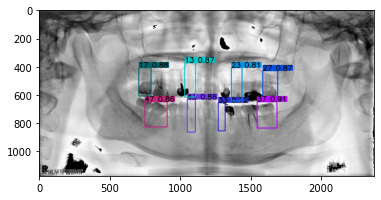

In [44]:
image_names = list(data_dir.glob('00008181.jpg'))

image_name = image_names[0]
filename = image_name.stem

results = model(image_name)
rendered_results = results.render()
detected_results = model(image_name)

plt.imshow(1 - rendered_results[0])
plt.show()


In [45]:
def crop_by_two_tooth(left, right, margin=50):
    # y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    x_items = torch.Tensor([left[2], right[0]])
    y_items = torch.Tensor([left[1], left[3], right[1], right[3]])

    crop = torch.Tensor([
        torch.min(x_items) - margin,
        torch.min(y_items),
        torch.max(x_items) + margin,
        torch.max(y_items) + margin,
    ])
    crop = crop.int()

    return crop


flag_dict = {
    'upper': [
        '17', '13', '23', '27'
    ],
    'lower': [
        '47', '43', '33', '37'
    ]
}

tooth_number_flag_dict = {
    '1': ('upper', 'left'),
    '2': ('upper', 'right'),
    '3': ('lower', 'right'),
    '4': ('lower', 'left'),
}

tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}


In [46]:
images = {}
split_teeth = {}

file_name = detected_results.files[0][:-4]
bounds = detected_results.xyxy[0]
img = detected_results.imgs[0]


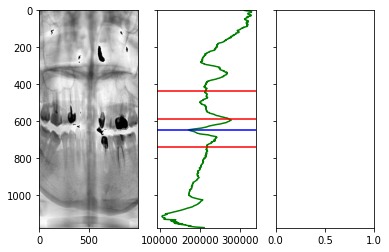

In [47]:
im_g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
height, width = im_g.shape
middle_height, middle_width = height // 2, width // 2

hor, _ = integral_intensity_projection(im_g)
bias_range = 150
narrow_hor = hor[middle_height - bias_range: middle_height + bias_range]
middle_height = narrow_hor.argmin() + middle_height - bias_range

# Plot area
index = np.array(range(height))
fig, axs = plt.subplots(1, 3, sharey='all')
# row i col 0
# image = vertical_line_drawing(image, *window_position, color=0)
axs[0].imshow(1 - im_g[:, width // 2 - 500:width // 2 + 500], aspect='auto', cmap='gray')
# for v in default_return[:2]:
#     axs[0].axhline(y=v, color='r')

# row i col 1
axs[1].plot(hor, index, 'g')
# axs[i][1].xaxis.tick_top()
axs[1].set_ylim(height, 0)
axs[1].axhline(y=height // 2, color='r')
axs[1].axhline(y=height // 2 + bias_range, color='r')
axs[1].axhline(y=height // 2 - bias_range, color='r')
axs[1].axhline(y=middle_height, color='b')
# for v in np.where(np.logical_and(hor_slope > -20, hor_slope < 20))[0]:
#     axs[1].axhline(y=v, color='r')

# axs[2].plot(hor_half, index, 'g')
# axs[i][1].xaxis.tick_top()
# axs[2].set_ylim(height, 0)


In [68]:
def test_curve_factory(a=-0.0004):
    def foo(x):
        return a * (x - middle_width) ** 2 + middle_height

    return foo


weight_list = [-0.0002, -0.0003, -0.0004, -0.0005, ]
curve_intensity = []
for j in range(4):
    weight = weight_list[i]

    draw_x = np.linspace(0, width - 1, 1000).astype(np.int32)
    draw_y = np.array(list(map(test_curve_factory(weight), draw_x))).astype(np.int32)

    draw_x = draw_x[draw_y > 0]
    draw_y = draw_y[draw_y > 0]
    curve_intensity.append(sum(im_g[draw_y, draw_x]))
curve_intensity = np.array(curve_intensity)
vertical_test_curve = test_curve_factory(weight_list[curve_intensity.argmin()])


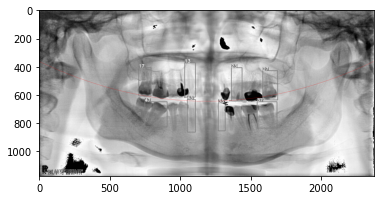

[{'xyxy': tensor([[1548.06885],
          [ 649.33246],
          [1689.91016],
          [ 835.81665]], device='cuda:0'),
  'name': '37'},
 {'xyxy': tensor([[708.22021],
          [408.09583],
          [795.15741],
          [608.73615]], device='cuda:0'),
  'name': '17'},
 {'xyxy': tensor([[1588.51050],
          [ 429.23999],
          [1694.58667],
          [ 636.08057]], device='cuda:0'),
  'name': '27'},
 {'xyxy': tensor([[1034.89880],
          [ 373.63434],
          [1110.22339],
          [ 616.94366]], device='cuda:0'),
  'name': '13'},
 {'xyxy': tensor([[751.66937],
          [649.33502],
          [909.33691],
          [827.33191]], device='cuda:0'),
  'name': '47'},
 {'xyxy': tensor([[1052.54773],
          [ 633.87085],
          [1110.01770],
          [ 864.27191]], device='cuda:0'),
  'name': '43'},
 {'xyxy': tensor([[1365.20667],
          [ 408.73663],
          [1441.75916],
          [ 644.47595]], device='cuda:0'),
  'name': '23'},
 {'xyxy': tensor([[1272.1331

In [69]:
tooth_bounds = []
for j in range(len(bounds)):
    *xyxy, _, cls = bounds[j]
    xyxy = torch.vstack(xyxy)
    mid_xy = [(xyxy[0] + xyxy[2]) / 2, (xyxy[1] + xyxy[3]) / 2]

    cls = int(cls.item())
    name = detected_results.names[cls]

    vertical_pos, horizon_pos = tooth_number_flag_dict[name[0]]
    testing_height = vertical_test_curve(mid_xy[0])

    vertical_test = mid_xy[1] < testing_height if vertical_pos == 'upper' else mid_xy[1] > testing_height
    horizon_test = mid_xy[0] < middle_width if horizon_pos == 'left' else mid_xy[0] > middle_width

    if vertical_test and horizon_test:
        change_dict = {1: 1, 2: 2, 3: 3, 4: 4}
    elif vertical_test and not horizon_test:
        change_dict = {1: 2, 2: 1, 3: 4, 4: 3}
    elif not vertical_test and horizon_test:
        change_dict = {1: 4, 4: 1, 2: 3, 3: 2}
    else:
        change_dict = {1: 3, 2: 4, 3: 1, 4: 2}

    new_name = str(change_dict[int(name[0])]) + name[1]
    tooth_bounds.append({'xyxy': xyxy, 'name': new_name})

draw_im = img.copy()

# create 1000 equally spaced points between -10 and 10
draw_x = np.linspace(0, width, 1000)

# calculate the y value for each element of the x vector
draw_y = np.array(list(map(vertical_test_curve, draw_x)))
draw_points = np.asarray([draw_x, draw_y]).T.astype(np.int32)

annotator = Annotator(1 - draw_im, line_width=3)
for tooth_bound in tooth_bounds:
    xyxy = tooth_bound['xyxy']
    tooth_number = tooth_bound['name']

    annotator.box_label(xyxy, str(tooth_number))

im1 = annotator.result()
im1 = cv2.polylines(im1, [draw_points], False, (255, 0, 0))  # args: image, points, closed, color
plt.imshow(im1)
# plt.plot(x, y)
# plt.axhline(y=middle_height, color='r')
# plt.axvline(x=middle_width, color='b')
plt.savefig('temp.png', dpi=300)
plt.show()

tooth_bounds


In [50]:
images[file_name] = []
split_teeth[file_name] = {}
for flag in ('upper', 'lower'):
    teeth_dict = {}
    flag_list = flag_dict[flag]

    for j in range(len(tooth_bounds)):
        xyxy = tooth_bounds[j]['xyxy']
        name = tooth_bounds[j]['name']

        teeth_dict[name] = xyxy

        crop_image = crop_by_xyxy(img, xyxy.int())
        split_teeth[file_name][name] = {'xyxy': xyxy, 'crop_image': crop_image}

        # roi image crop
        teeth_detected_flag = [f in teeth_dict for f in flag_list]
        tooth_detected_tuples = [(flag_list[j], flag_list[j + 1], j) for j in range(len(flag_list) - 1) if
                                 teeth_detected_flag[j] and teeth_detected_flag[j + 1]]

        for left_tooth_number, right_tooth_number, number in tooth_detected_tuples:
            left_tooth = teeth_dict[left_tooth_number]
            right_tooth = teeth_dict[right_tooth_number]

            region = crop_by_two_tooth(left_tooth, right_tooth)
            tooth_position = tooth_position_dict[number]

            save_filename = f'{flag}-{number}-{file_name}'
            save_file = Path(f'./crops/{save_filename}.jpg')

            im = save_one_box(region, img, save=False, file=save_file)
            # print(f'First ROI process: {save_filename} done.')

            image_data = {
                'flag': flag,
                'number': number,
                'tooth_position': tooth_position,
                'org_file_name': file_name,
                'offset': np.array([region[0], region[1]]),
                'image': im,
                'xyxy': region,
            }

            images[file_name].append(image_data)

images


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\yolov5\utils\plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


{'00008181': [{'flag': 'upper',
   'number': 0,
   'tooth_position': 'left',
   'org_file_name': '00008181',
   'offset': array([745, 373]),
   'image': array([[[160, 160, 160],
           [154, 154, 154],
           [155, 155, 155],
           ...,
           [122, 122, 122],
           [123, 123, 123],
           [123, 123, 123]],
   
          [[168, 168, 168],
           [158, 158, 158],
           [156, 156, 156],
           ...,
           [120, 120, 120],
           [122, 122, 122],
           [123, 123, 123]],
   
          [[173, 173, 173],
           [160, 160, 160],
           [153, 153, 153],
           ...,
           [117, 117, 117],
           [120, 120, 120],
           [121, 121, 121]],
   
          ...,
   
          [[151, 151, 151],
           [153, 153, 153],
           [156, 156, 156],
           ...,
           [ 51,  51,  51],
           [ 52,  52,  52],
           [ 52,  52,  52]],
   
          [[152, 152, 152],
           [154, 154, 154],
           [157, 15

In [51]:
images.values()



dict_values([[{'flag': 'upper', 'number': 0, 'tooth_position': 'left', 'org_file_name': '00008181', 'offset': array([745, 373]), 'image': array([[[160, 160, 160],
        [154, 154, 154],
        [155, 155, 155],
        ...,
        [122, 122, 122],
        [123, 123, 123],
        [123, 123, 123]],

       [[168, 168, 168],
        [158, 158, 158],
        [156, 156, 156],
        ...,
        [120, 120, 120],
        [122, 122, 122],
        [123, 123, 123]],

       [[173, 173, 173],
        [160, 160, 160],
        [153, 153, 153],
        ...,
        [117, 117, 117],
        [120, 120, 120],
        [121, 121, 121]],

       ...,

       [[151, 151, 151],
        [153, 153, 153],
        [156, 156, 156],
        ...,
        [ 51,  51,  51],
        [ 52,  52,  52],
        [ 52,  52,  52]],

       [[152, 152, 152],
        [154, 154, 154],
        [157, 157, 157],
        ...,
        [ 51,  51,  51],
        [ 52,  52,  52],
        [ 53,  53,  53]],

       [[163, 163, 163],